In [1]:
import sklearn
sklearn.__version__

'0.23.1'

In [2]:
from itertools import product
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.datasets import load_iris
# For votingclassifier ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
# Support vector machine classifier - details in https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
from sklearn.svm import SVC
# StandardScaler for scaling the dataset
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              AdaBoostClassifier)
from sklearn.tree import DecisionTreeClassifier

# 2. Ensemble Learning
----------------------
## a. VotingClassifier
----------------------
### VotingClassifier(estimators, *, voting='hard', weights=None, n_jobs=None, flatten_transform=True, verbose=False)
* #### Arguments: only "estimators" matters for now
 1.         estimators: list of (str, estimator) tuples - Invoking the fit method on the VotingClassifier will fit clones of those original estimators that will be stored in the class attribute self.estimators_. An estimator can be set to 'drop' using set_params.
  2.         voting : {‘hard’, ‘soft’}, default=’hard’- If ‘hard’, uses predicted class labels for majority rule voting. Else if ‘soft’, predicts the class label based on the argmax of the sums of the predicted probabilities, which is recommended for an ensemble of well-calibrated classifiers.
  3.       weights : array-like of shape (n_classifiers,), default=None - Sequence of weights (float or int) to weight the occurrences of predicted class labels (hard voting) or class probabilities before averaging (soft voting). Uses uniform weights if None.
  4.         n_jobs : int, default=None - The number of jobs to run in parallel for fit. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. 
  5.         flatten_transform : bool, default=True - Affects shape of transform output only when voting=’soft’ If voting=’soft’ and flatten_transform=True, transform method returns matrix with shape (n_samples, n_classifiers * n_classes). If flatten_transform=False, it returns (n_classifiers, n_samples, n_classes).
  6.         verbose : bool, default=False - If True, the time elapsed while fitting will be printed as it is completed.
* #### Artributes: (of the VotingClassifier object)
 *         estimators_ : list of classifiers - The collection of fitted sub-estimators as defined in estimators that are not ‘drop’.
 *         classes_ : array-like of shape (n_predictions,) - The classes labels.
* #### Methods: (on the VotingClassifier object)
 *         fit(self, X, y[, sample_weight]) : Fit the estimators.
 *         fit_transform(self, X[, y]) : Fit to data, then transform it.
 *         get_params(self[, deep]) : Get the parameters of an estimator from the ensemble.
 *         predict(self, X) : Predict class labels for X.
 *         score(self, X, y[, sample_weight]) : Return the mean accuracy on the given test data and labels.
 *         set_params(self, \*\*params) : Set the parameters of an estimator from the ensemble.
 *         transform(self, X) : Return class labels or probabilities for X for each estimator.

In [3]:
#read in the dataset
df = pd.read_csv('dataset/datasets_diabetes.csv')
#take a look at the data
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
# X : dataset feature, y : dataset label
X = df.drop(columns = ['Outcome'])
y = df['Outcome']
# normalize dataset for training
X = StandardScaler().fit_transform(X)
#split data into train and test sets - Ratio : 4:1 (4 for training, 1 for test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

## [문제] 주어진 Training data를 최적화 하는 3개의 모델 (KNeighborsClassifier, LogisticRegression, SVC)을 이용하여 Ensemble Learning 한 결과를 출력하시오.
1. 각 모델의 instance를 knn, log_reg, svc로 생성하고 각 모델의 accuracy score를 출력하시오. 
2. VotingClassifier를 이용한 Ensemble 모델을 생성 후 Fitting 시키고 accuracy score를 출력하시오.


In [5]:
#create new a knn model
### YOUR CODE HERE (Fill in the "None")
# Hint: knn is a default KNeighborsClassifier object. 
knn = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
params_knn = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gs = GridSearchCV(knn, params_knn, cv=5)
#fit model to training data
knn_gs.fit(X_train, y_train)

#create a new logistic regression model
# Hint: log_reg is a default LogisticRegression object.
log_reg = LogisticRegression()
#fit the model to the training data
log_reg.fit(X_train, y_train)

# create new support vector machine classifier
# Hint: svc is a SVC object which enable probability estimates. 
# Hint: It can be handled by 'probability' parameter whose value is boolean.
# Important : Use probabilistic Support Vector Machine Classifier, 
# which outputs class probability(For soft ensemble, as we will describe later)
svc = SVC(probability=True)
#fit the model to the training data
svc.fit(X_train, y_train)

# Check the accuracy score of all 3 model. for diabete prediction
print('knn: {}'.format(knn_gs.score(X_test, y_test)))
print('svc: {}'.format(svc.score(X_test, y_test)))
print('log_reg: {}'.format(log_reg.score(X_test, y_test)))

knn: 0.6818181818181818
svc: 0.7207792207792207
log_reg: 0.7467532467532467


In [6]:
# create a 'estimators' for VotingClassifier parameter - Hard voting(Majority rule)
# Hint: Parameter 'estimators' of VotingClassifier : list of (str, estimator) tuples
estimators=[('knn', knn_gs), ('svc', svc), ('log_reg', log_reg)]
# create VotingClassifier estimator - Weighted majority ensemble model
# Hint: If the parameter 'voting' is `hard', uses predicted class labels for majority rule voting. 
# Hint: Else if ‘soft’, predicts the class label based on the argmax of the sums of the predicted probabilities, which is recommended for an ensemble of well-calibrated classifiers.
ensemble_hard = VotingClassifier(estimators, voting='hard')
# Train weight of VotingClassifier object for ensemble using training dataset
ensemble_hard.fit(X_train, y_train)
# score the result of ensemble model on test dataset
ensemble_hard.score(X_test, y_test)

0.7207792207792207

In [7]:
# create a VotingClassifier estimator - Soft voting(Average class probability)
# Hint: If the parameter 'voting' is `hard', uses predicted class labels for majority rule voting. 
# Hint: Else if ‘soft’, predicts the class label based on the argmax of the sums of the predicted probabilities, which is recommended for an ensemble of well-calibrated classifiers.
ensemble_soft = VotingClassifier(estimators, voting='soft')
ensemble_soft.fit(X_train, y_train)
ensemble_soft.score(X_test, y_test)

0.7337662337662337

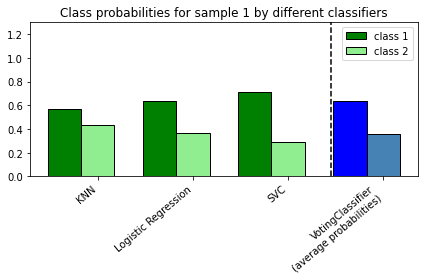

In [8]:
# plotting
# obtain class probabilities for all 4 models - KNN, Logistic Regression, SVC, ensemble
probas = [c.predict_proba(X_test) for c in (knn_gs, log_reg, svc, ensemble_soft)]
# get class probabilities for the first sample in the dataset
class1_1 = [pr[0, 0] for pr in probas]
class2_1 = [pr[0, 1] for pr in probas]

N = 4  # number of groups
ind = np.arange(N)  # group positions
width = 0.35  # bar width

fig, ax = plt.subplots()

# bars for classifier 1-3
p1 = ax.bar(ind, np.hstack(([class1_1[:-1], [0]])), width,
            color='green', edgecolor='k')
p2 = ax.bar(ind + width, np.hstack(([class2_1[:-1], [0]])), width,
            color='lightgreen', edgecolor='k')

# bars for VotingClassifier
p3 = ax.bar(ind, [0, 0, 0, class1_1[-1]], width,
            color='blue', edgecolor='k')
p4 = ax.bar(ind + width, [0, 0, 0, class2_1[-1]], width,
            color='steelblue', edgecolor='k')

# plot annotations
plt.axvline(2.8, color='k', linestyle='dashed')
ax.set_xticks(ind + width)
ax.set_xticklabels(['KNN',
                    'Logistic Regression',
                    'SVC',
                    'VotingClassifier\n(average probabilities)'],
                   rotation=40,
                   ha='right')
plt.ylim([0, 1.3])
plt.title('Class probabilities for sample 1 by different classifiers')
plt.legend([p1[0], p2[0]], ['class 1', 'class 2'], loc='upper right')
plt.tight_layout()
plt.show()

## Reference
1. https://scikit-learn.org/stable/modules/ensemble.html
2. https://towardsdatascience.com/ensemble-learning-using-scikit-learn-85c4531ff86a  
3. https://stackabuse.com/ensemble-voting-classification-in-python-with-scikit-learn/ 
4. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html